In [1]:
from fastai.imports import *
import seaborn as sns
import graphviz
from pickle import dump, load
import statsmodels.api as sm
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score

# Dataset Preparation

In [2]:
df = pd.read_csv('./references/09 data clean.csv')
df.head()

,ID,Home,Age,Religion,Ethnicity,Education,Occupation,Income,Marital,Smoke,...,filter_$,religionnew,ethnicitynew,incomenew,maritalnew,educationnew,occupationnew,smokenew,alcoholnew,partnernew
0,7,1,17,3,3,2,4,1,1,3,...,0,0,0,1,1,1,3,0,0,0
1,9,1,15,1,5,1,4,1,1,3,...,0,1,0,1,1,0,3,0,0,0
2,11,1,14,1,1,1,2,1,1,3,...,0,1,1,1,1,0,1,0,0,0
3,15,1,15,1,1,2,4,1,1,3,...,0,1,1,1,1,1,3,0,0,0
4,43,1,17,1,1,2,4,1,1,3,...,0,1,1,1,1,1,3,0,0,0


In [3]:
cats=['religionnew', 'ethnicitynew', 'educationnew', 'occupationnew',
       'incomenew', 'maritalnew', 'smokenew', 'alcoholnew', 'partnernew',
       'EV', 'CB', 'PV', 'SV', 'IPV']
conts=['Age']
# dep="MINIdepression"
# dep="Panxiety"
dep="PPTSD"
for label in cats:
    df[label] = pd.Categorical(df[label])

In [4]:
df[dep].describe()

count    91.000000
mean      0.670330
std       0.472698
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: PPTSD, dtype: float64

## Save all plot in figures

## Split Dataset

In [7]:
trn_df,val_df = train_test_split(df, test_size=0.2, stratify=df[dep])

In [8]:
trn_df[dep].value_counts()

PPTSD
1    48
0    24
Name: count, dtype: int64

In [9]:
val_df[dep].value_counts()

PPTSD
1    13
0     6
Name: count, dtype: int64

> The distribution between the dependent variable seem ok.

## Selecting Features

In [10]:
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [11]:
print(f'Training Shape: {trn_xs.shape}')
print(f'Validation Shape: {val_xs.shape}')

Training Shape: (72, 15)
Validation Shape: (19, 15)


> Bear in mind that the df is no longer categorical

In [12]:
pd.set_option('display.max_columns', None)

In [13]:
trn_xs

,religionnew,ethnicitynew,educationnew,occupationnew,incomenew,maritalnew,smokenew,alcoholnew,partnernew,EV,CB,PV,SV,IPV,Age
42,1,1,1,2,0,1,0,0,1,1,1,1,1,1,18
82,1,1,1,1,1,0,0,0,1,1,1,1,1,1,38
30,1,1,0,2,1,1,0,1,1,1,1,0,1,1,16
69,1,1,1,1,1,1,0,0,1,0,1,0,0,1,22
31,1,1,0,2,1,1,1,1,1,0,1,0,1,1,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,1,1,0,1,1,1,0,0,1,0,1,0,0,1,19
9,1,1,1,1,1,1,0,0,1,0,1,0,1,1,15
66,1,1,1,1,1,1,0,0,1,0,1,0,1,1,19
15,1,1,1,2,0,1,1,2,1,1,1,1,0,1,15


In [14]:
trn_y

42    1
82    1
30    1
69    0
31    0
     ..
68    0
9     1
66    0
15    1
77    1
Name: PPTSD, Length: 72, dtype: int64

In [15]:
val_xs

,religionnew,ethnicitynew,educationnew,occupationnew,incomenew,maritalnew,smokenew,alcoholnew,partnernew,EV,CB,PV,SV,IPV,Age
48,1,1,1,0,0,1,0,2,1,1,1,0,1,1,17
23,1,1,1,0,1,1,1,0,1,0,1,0,1,1,15
12,0,0,0,2,1,1,1,1,1,1,1,1,0,1,16
29,1,1,0,2,1,1,0,0,1,0,1,0,1,1,21
14,0,0,1,2,1,1,1,2,1,1,0,0,1,1,14
10,1,1,1,2,1,1,1,2,1,1,0,0,1,1,15
64,1,1,1,2,0,1,0,2,1,1,1,1,1,1,16
0,0,0,1,2,1,1,0,0,0,0,0,0,0,0,17
87,1,1,1,0,1,0,0,1,1,0,1,0,0,1,29
3,1,1,1,2,1,1,0,0,0,0,0,0,0,0,15


In [16]:
val_y

48    1
23    1
12    1
29    0
14    1
10    1
64    1
0     1
87    0
3     0
89    1
5     1
88    0
25    1
37    0
20    1
65    1
4     1
8     0
Name: PPTSD, dtype: int64

# Logistic Regression

## Model Training and Prediction

In [17]:
logreg = LogisticRegression()
logreg.fit(trn_xs, trn_y)
y_pred = logreg.predict(val_xs)

## Model Evaluation

### MAE For Validation Set

In [18]:
mean_absolute_error(val_y, y_pred)

0.3157894736842105

### MAE For Training Set

In [19]:
y_train_pred = logreg.predict(trn_xs)
mean_absolute_error(trn_y, y_train_pred)

0.2638888888888889

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

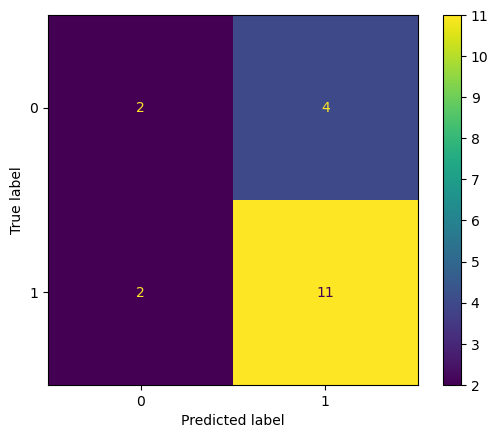

In [20]:
# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is not very confidence in classifying if a subject is depressed or not. If the purple boxes is more towards zero, the better it is since that means the model did never guessed wrong.

### Accuracy, Precision, Recall

In [21]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6842105263157895
Precision: 0.7333333333333333
Recall: 0.8461538461538461


Accuracy: In general, when the model makes prediction, it is right 57% of the time.

Precision: This is the accuracy of the Positive Prediction. For 60% precision for "with depression as positive", that means, for a list of patients that our model predicted as depressed, 60% of them IS in fact depressed, while the other 40% is not actually depressed but wrongly predicted as so. The downside is, it does not count missing POSITIVE, that is, our model can pick a few patients where it is confident that they are depressed and achieved High Precision, but left out many patients that are actually depressed but missed out by our model.

Recall: It is the ability of the model to detect the target. If there are 100 depressed patient in a list of X (let say 1000), and our model correctly labelled all 100 depressed patient as depressed, that means the recall is 100%. It does not matter if the model also predicted other non-depressed patient as depressed (False Positive), as it does not count in recall calculation. But too many False Positive can be inconvenient where manual intervention must be made to filter them out and make the labelling correct again.

### Classification Report

In [22]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y, y_pred, target_names=target_names))

               precision    recall  f1-score   support

without PPTSD       0.50      0.33      0.40         6
   with PPTSD       0.73      0.85      0.79        13

     accuracy                           0.68        19
    macro avg       0.62      0.59      0.59        19
 weighted avg       0.66      0.68      0.66        19



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

### ROC Curve

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

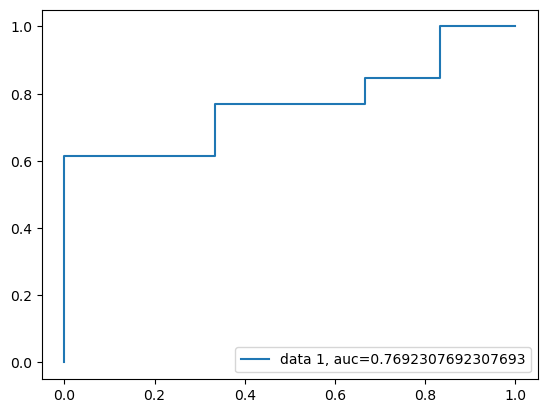

In [23]:
y_pred_proba = logreg.predict_proba(val_xs)[:,1]
fpr, tpr, _ = roc_curve(val_y,  y_pred_proba)
auc = roc_auc_score(val_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

> AUC score for the case is 0.55. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.

### Feature Importance

#### By Training Set

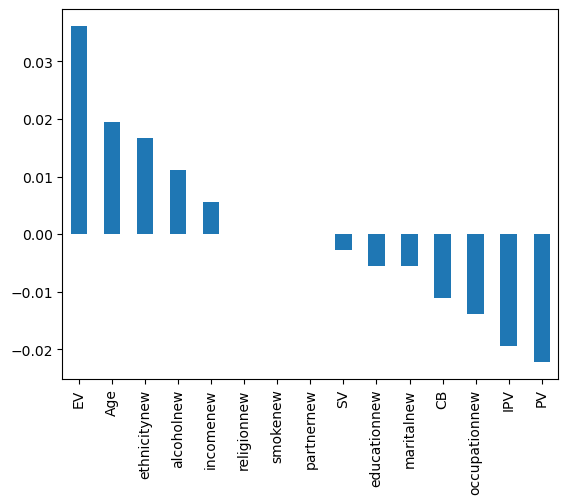

In [24]:
logreg_fi = permutation_importance(logreg, trn_xs, trn_y)
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(logreg_fi['importances_mean'], index=trn_xs.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

Where Y-axis is: Change in Mean Squared Error.

The left most means, changing this features will result in the RMSE to increase (about 0.04 for EV).
Meaning the model is highly dependent on these features.

Zero means changing the feature does not affect the model much.

X-axis is: Name of features in this model.

#### By Validation Set

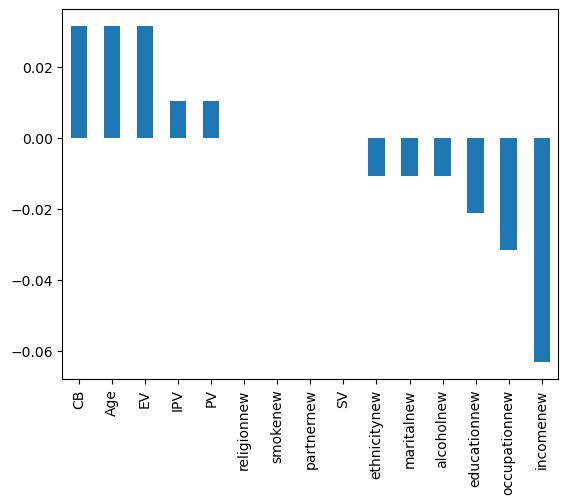

In [25]:
logreg_fi_val = permutation_importance(logreg, val_xs, val_y)

feature_importances = pd.Series(logreg_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

> Bear in mind that this model is not considered a good model by our Evaluation above (eg. AUC Score). So we cannot say for certain that the feature importance found above has a significant value to our conclusion. However we can still take it onto our consideration for further analysis.

> Also bear in mind, we get different result each time we refresh the code due to the randomness. However I found that EV is always on top of the other feature in importance.

#### Playground To Rerun

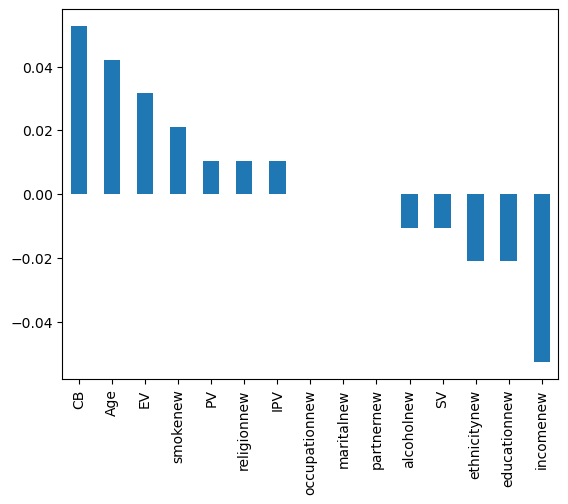

In [34]:
logreg_fi_val = permutation_importance(logreg, val_xs, val_y)

feature_importances = pd.Series(logreg_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

---

# Random Forest

## Model Training and Prediction

In [35]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y)
y_pred = rf.predict(val_xs)

## Model Evaluation

### MAE For Validation Set

In [36]:
mean_absolute_error(val_y, y_pred)

0.3157894736842105

### MAE For Training Set

In [37]:
y_train_pred = rf.predict(trn_xs)
mean_absolute_error(trn_y, y_train_pred)

0.2916666666666667

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

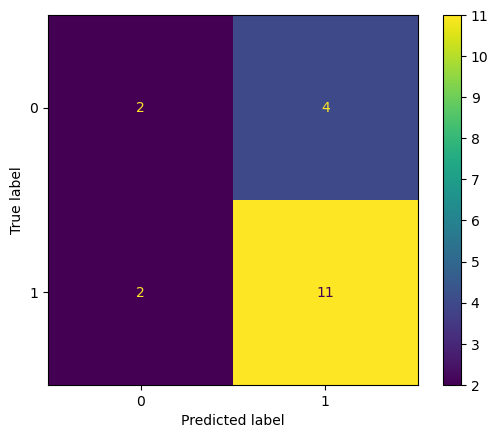

In [38]:
# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is not very confidence in classifying if a subject is depressed or not.

### Accuracy, Precision, Recall

In [39]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6842105263157895
Precision: 0.7333333333333333
Recall: 0.8461538461538461


Accuracy: In general, when the model makes prediction, it is right 63% of the time.

Precision: This is the accuracy of the Positive Prediction. For 60% precision for "with depression as positive", that means, for a list of patients that our model predicted as depressed, 60% of them IS in fact depressed, while the other 40% is not actually depressed but wrongly predicted as so. The downside is, it does not count missing POSITIVE, that is, our model can pick a few patients where it is confident that they are depressed and achieved High Precision, but left out many patients that are actually depressed but missed out by our model.

Recall: It is the ability of the model to detect the target. If there are 100 depressed patient in a list of X (let say 1000), and our model correctly labelled all 100 depressed patient as depressed, that means the recall is 100%. It does not matter if the model also predicted other non-depressed patient as depressed (False Positive), as it does not count in recall calculation. But too many False Positive can be inconvenient where manual intervention must be made to filter them out and make the labelling correct again.

### Classification Report

In [40]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y, y_pred, target_names=target_names))

               precision    recall  f1-score   support

without PPTSD       0.50      0.33      0.40         6
   with PPTSD       0.73      0.85      0.79        13

     accuracy                           0.68        19
    macro avg       0.62      0.59      0.59        19
 weighted avg       0.66      0.68      0.66        19



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

### ROC Curve

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

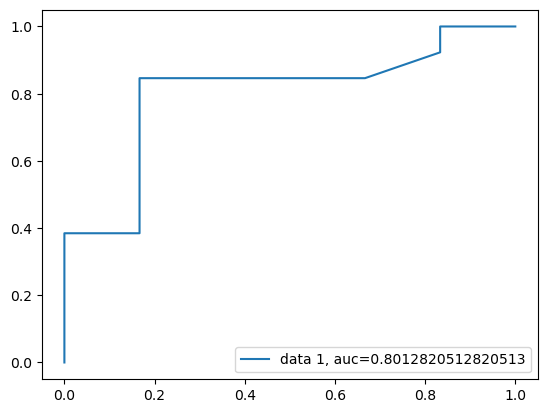

In [41]:
y_pred_proba = rf.predict_proba(val_xs)[:,1]
fpr, tpr, _ = roc_curve(val_y,  y_pred_proba)
auc = roc_auc_score(val_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

> AUC score for the case is 0.56. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.
> This is slighly better than the Logistic Regression

### Permutation Importance

#### By Training Set

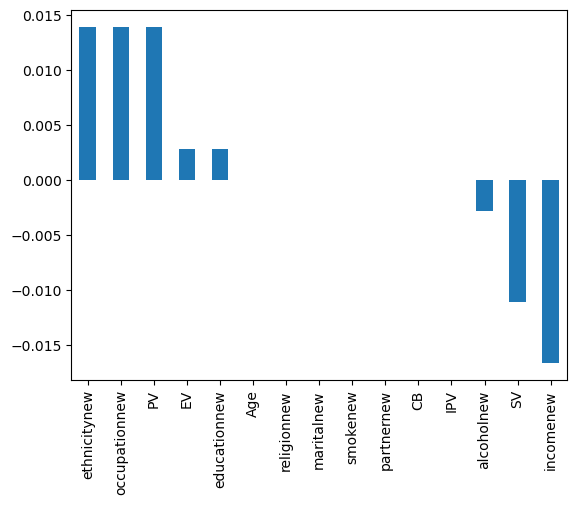

In [42]:
rf_fi = permutation_importance(rf, trn_xs, trn_y)

feature_importances = pd.Series(rf_fi['importances_mean'], index=trn_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

Where Y-axis is: Change in Mean Squared Error.

The left most means, changing this features will result in the RMSE to increase (about 0.1 for EV).
Meaning the model is highly dependent on these features.

Zero means changing the feature does not affect the model much.

X-axis is: Name of features in this model.

#### By Validation Set

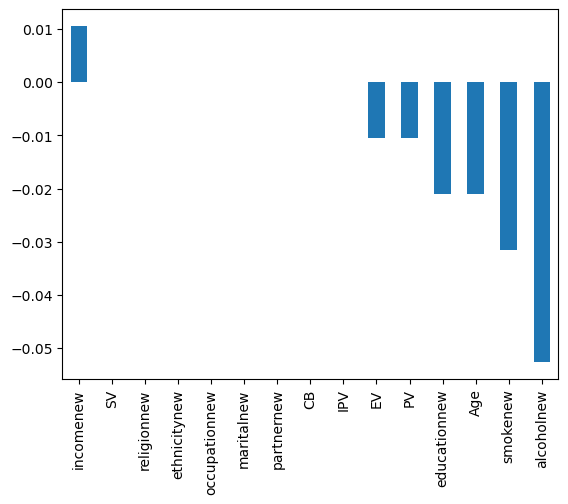

In [43]:
rf_fi_val = permutation_importance(rf, val_xs, val_y)

feature_importances = pd.Series(rf_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

> Bear in mind that this model is not considered a good model by our Evaluation above (eg. AUC Score). So we cannot say for certain that the feature importance found above has a significant value to our conclusion. However we can still take it onto our consideration for further analysis.

> Also bear in mind, we get different result each time we refresh the code due to the randomness. However I found that EV is always on top of the other feature in importance.

#### Playground To Rerun

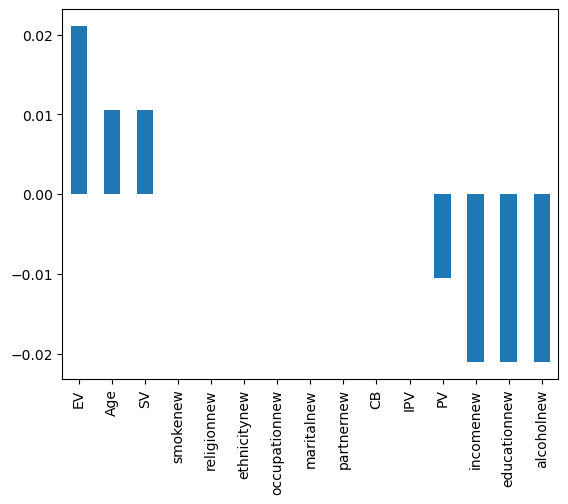

In [45]:
rf_fi_val = permutation_importance(rf, val_xs, val_y)

feature_importances = pd.Series(rf_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

### Feature Importance

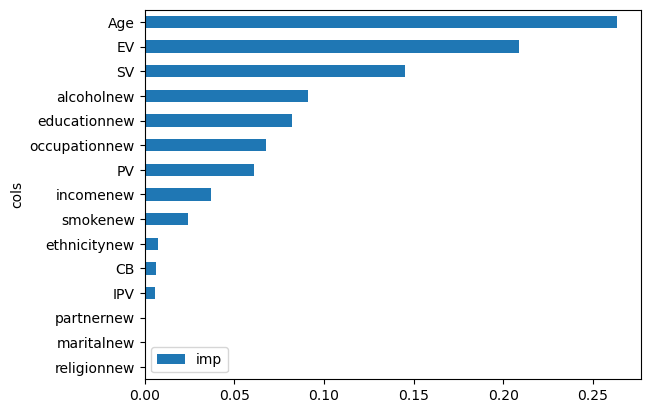

In [46]:
imp = rf.feature_importances_
pd.DataFrame(dict(cols=trn_xs.columns, imp=imp)).sort_values(by='imp', ascending=True).plot('cols', 'imp', 'barh');

> The bottom three feature is what we were expecting from the histogram where the sample is very small for one side.

### Visualizing the Results

We can use the following code to visualize our first 3 trees.

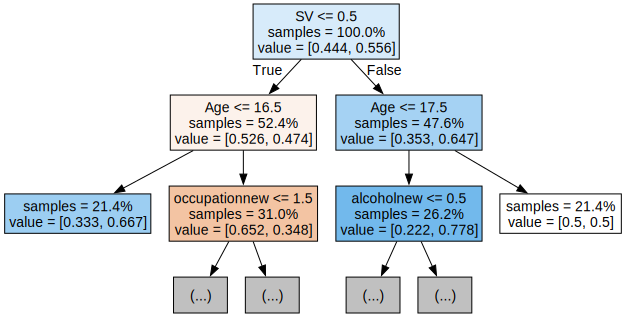

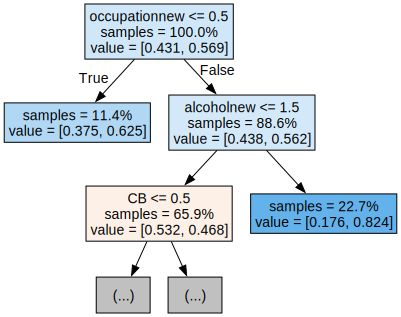

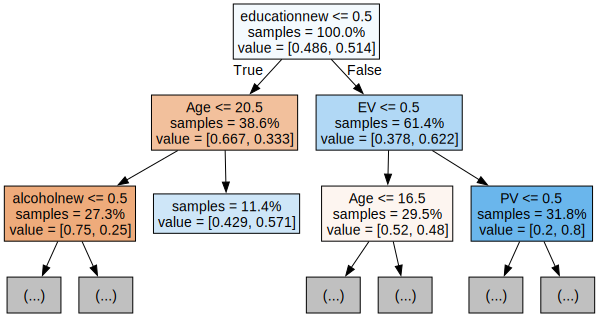

In [32]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=trn_xs.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Hyperparameter Tuning

In [47]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf2 = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf2, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(trn_xs, trn_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B29474D390>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B295C80D50>})

In [48]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

y_pred = best_rf.predict(val_xs)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 2, 'n_estimators': 495}


### Model Evaluation

#### MAE For Validation Set

In [49]:
mean_absolute_error(val_y, y_pred)

0.2631578947368421

### MAE For Training Set

In [50]:
y_train_pred = best_rf.predict(trn_xs)
mean_absolute_error(trn_y, y_train_pred)

0.2916666666666667

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

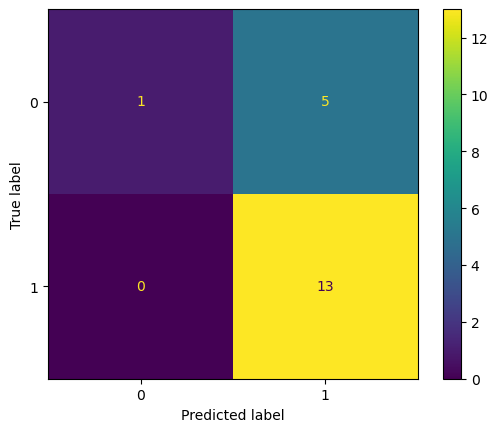

In [51]:
# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is somewhat confidence in classifying if a subject is depressed or not.

### Accuracy, Precision, Recall

In [52]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7368421052631579
Precision: 0.7222222222222222
Recall: 1.0


### Classification Report

In [53]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y, y_pred, target_names=target_names))

               precision    recall  f1-score   support

without PPTSD       1.00      0.17      0.29         6
   with PPTSD       0.72      1.00      0.84        13

     accuracy                           0.74        19
    macro avg       0.86      0.58      0.56        19
 weighted avg       0.81      0.74      0.66        19



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

### ROC Curve

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

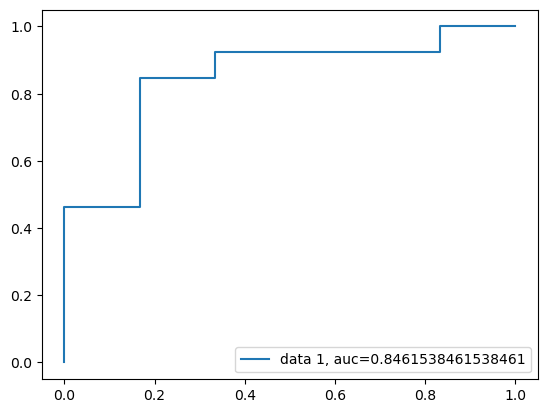

In [54]:
y_pred_proba = best_rf.predict_proba(val_xs)[:,1]
fpr, tpr, _ = roc_curve(val_y,  y_pred_proba)
auc = roc_auc_score(val_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

> AUC score for the case is 0.53. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.
> This is slighly better than the Logistic Regression?

### Permutation Importance

#### By Training Set

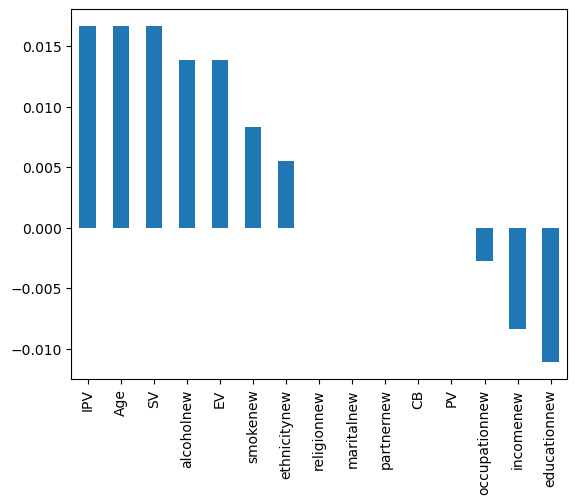

In [55]:
rf_pi = permutation_importance(best_rf, trn_xs, trn_y)

feature_importances = pd.Series(rf_pi['importances_mean'], index=trn_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

Where Y-axis is: Change in Mean Squared Error.

The left most means, changing this features will result in the RMSE to increase (about 0.16 for EV).
Meaning the model is highly dependent on these features.

Zero means changing the feature does not affect the model much.

X-axis is: Name of features in this model.

#### By Validation Set

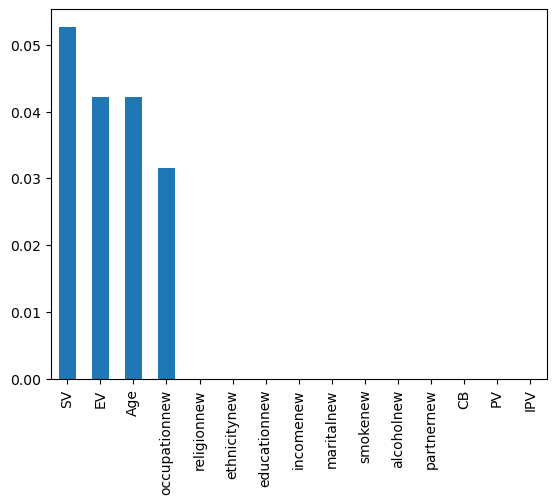

In [56]:
rf_pi_val = permutation_importance(best_rf, val_xs, val_y)

feature_importances = pd.Series(rf_pi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

### Feature Importance

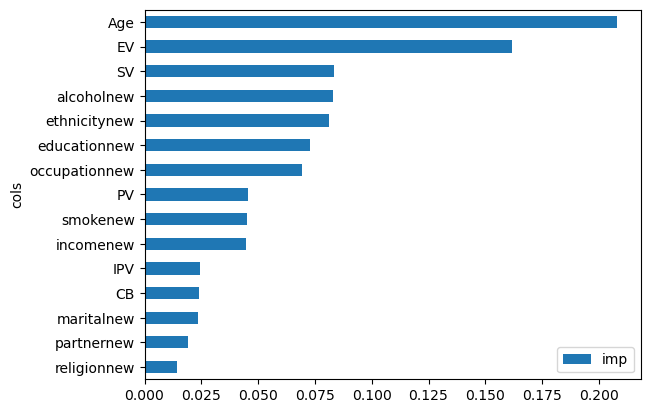

In [57]:
imp = best_rf.feature_importances_
pd.DataFrame(dict(cols=trn_xs.columns, imp=imp)).sort_values(by='imp', ascending=True).plot('cols', 'imp', 'barh');

> The bottom three feature is what we were expecting from the histogram where the sample is very small for one side.

### Visualizing the Results

We can use the following code to visualize our first 3 trees.

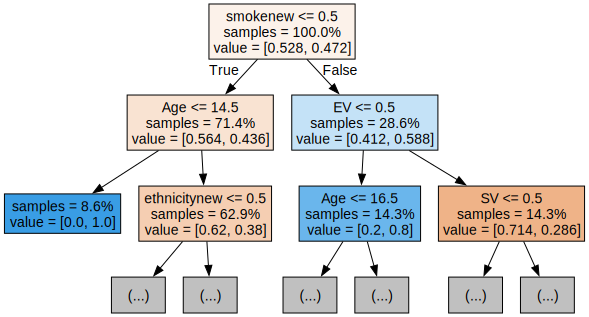

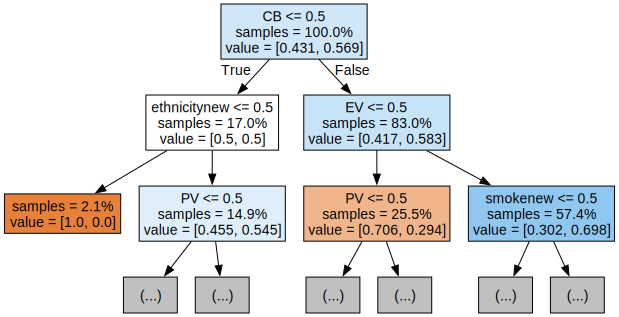

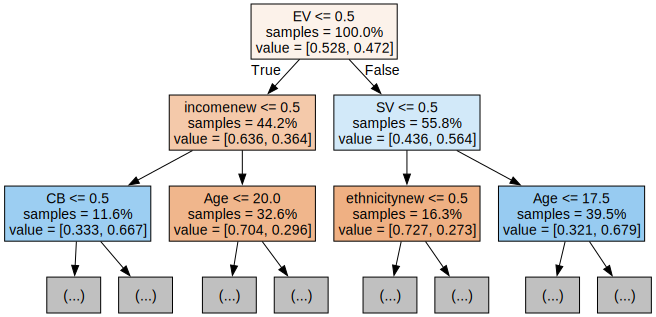

In [44]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=trn_xs.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Saving The Model

## Loading The Model

---

# Finding p-value

In [58]:
sm_X, sm_Y = xs_y(df)

In [59]:
sm_X2 = sm.add_constant(sm_X)

In [60]:
est = sm.OLS(sm_Y, sm_X2)

In [61]:
est2 = est.fit()

In [62]:
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PPTSD   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     2.095
Date:                Wed, 17 Jul 2024   Prob (F-statistic):             0.0191
Time:                        13:16:30   Log-Likelihood:                -44.512
No. Observations:                  91   AIC:                             121.0
Df Residuals:                      75   BIC:                             161.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.1836      0.728      3.000      0.004       0.734       3.634
religionnew      -0.0490      0.292     -0.168      0.867      -0.630       0.532
ethnicitynew     -0.1984      0.217     -0.915      0.363      -0.630       0.233
educationnew     -0.0224      0.119     -0.188      0.852      -0.260       0.215
occupationnew     0.0082      0.076      0.107      0.915      -0.144       0.160
incomenew        -0.1362      0.126     -1.077      0.285      -0.388       0.116
maritalnew       -0.6650      0.387     -1.718      0.090      -1.436       0.106
smokenew          0.0344      0.128      0.269      0.789      -0.221       0.289
alcoholnew        0.0511      0.063      0.807      0.422      -0.075       0.177
partnernew       -0.0353      0.266     -0.133      0.895      -0.565       0.494
EV                0.3614      0.123      2.947      0.004       0.117       0.606
CB                0.1302      0.245      0.532      0.597      -0.358       0.618
PV                0.0197      0.123      0.161      0.873      -0.225       0.264
SV                0.1678      0.118      1.418      0.160      -0.068       0.404
IPV              -0.4451      0.335     -1.330      0.187      -1.112       0.221
Age              -0.0337      0.016     -2.084      0.041      -0.066      -0.001
==============================================================================
Omnibus:                        6.506   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.197
Skew:                          -0.579   Prob(JB):                       0.0451
Kurtosis:                       2.460   Cond. No.                         346.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

# FastAI Tabular Learner

## Model Training and Prediction

In [63]:
from fastai.tabular.all import *

In [64]:
splits = RandomSplitter()(df)

In [65]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=cats,
    cont_names=conts,
    y_names=dep, y_block=CategoryBlock(),
).dataloaders(path='.')

In [144]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.12022644281387329, valley=0.004365158267319202)

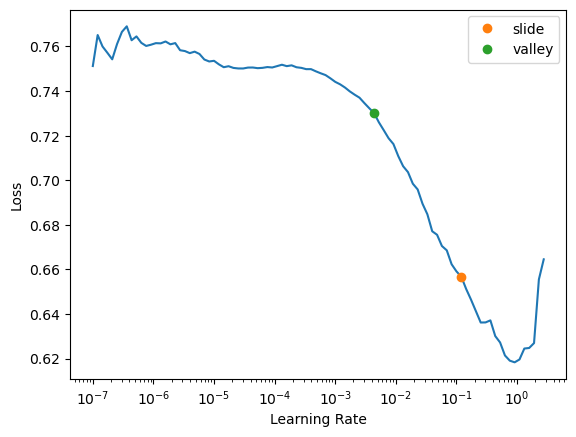

In [56]:
learn.lr_find(suggest_funcs=(slide, valley))

In [157]:
learn.fit(10, lr=0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.426328,0.362145,0.833333,00:00
1,0.422092,0.368439,0.888889,00:00
2,0.396673,0.365779,0.888889,00:00
3,0.383992,0.367151,0.888889,00:00
4,0.370347,0.364786,0.888889,00:00
5,0.359099,0.364247,0.944444,00:00
6,0.362971,0.359529,0.888889,00:00
7,0.360136,0.356201,0.888889,00:00
8,0.357022,0.362513,0.944444,00:00
9,0.356067,0.360097,0.944444,00:00


In [158]:
trn_split,val_split=splits

In [159]:
df.iloc[val_split]

,ID,Home,Age,Religion,Ethnicity,Education,Occupation,Income,Marital,Smoke,Smoking,Alcohol,Partner,P_Age,P_Education,P_Occupation,P_Alcohol,P_Drugs,P_Fights,P_Women,P_Child,SectionCQ1,SectionCQ2,SectionCQ3,SectionCQ4,SectionCQ5,SectionCQ6,SectionCQ7,SectionCQ8,SectionCQ9,SectionCQ10,SectionCQ11,SectionCQ12,SectionCQ13,SectionCQ14,SectionCQ15,SectionCQ16,SectionCQ17,SectionCQ18,SectionCQ19,SectionCQ20,SectionCQ21,SectionCQ22,SectionCQ23,SectionCQ24,SectionCQ25,SectionCQ26,SectionCQ27,SectionCQ28,SectionCQ29,SectionCQ30,SectionCQ31,SectionCQ32,SectionCQ33,SectionCQ34,SectionCQ35,SectionCQ36,SectionCQ37,SectionCQ38,SectionCQ39,SectionCQ40,SectionCQ41,SectionCQ42,SectionCQ43,SectionCQ44,SectionDQ1,SectionDQ1a,SectionDQ2,SectionDQ2a,SectionDQ3,SectionDQ3a,SectionDQ4,SectionDQ5,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,PHQ10,TPHQ,LDEPRESSION,PDEPRESSION,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,TANXIETY,Lanxiety,Panxiety,PCL1,PCL2,PCL3,PCL4,PCL5,PCL6,PCL7,PCL8,PCL9,PCL10,PCL11,PCL12,PCL13,PCL14,PCL15,PCL16,PCL17,PCL18,PCL19,PCL20,TPCL,PPTSD,MINI1,MINI1a,MINI2,MINI2a,MINI3,MINI4,MINI5,MINI6,MINI7,MINI8,MINI9,MINI10,MINI11,MINIdepression,EV,CB,PV,SV,IPV,filter_$,religionnew,ethnicitynew,incomenew,maritalnew,educationnew,occupationnew,smokenew,alcoholnew,partnernew
13,19,1,15,1,1,2,4,1,1,3,1,7,3,17,2,1,5,4,1,2,2,1,1,1,1,2,2,2,2,2,2,1,2,2,3,2,3,2,3,2,3,2,3,1,2,1,2,1,2,1,2,2,3,1,2,2,3,2,3,2,,,,,,1,13,1,13,1,13,4,1,0,1,1,1,0,1,0,0,0,1,4,1,0,0,0,0,1,0,1,1,3,1,0,1,0,1,2,3,2,0,0,1,3,3,0,0,0,3,0,4,3,0,4,30,0,1,1,2,,2,2,1,2,2,2,2,2,2,0,0,1,1,1,1,1,1,1,1,1,1,3,0,0,1
62,61,1,14,1,1,2,4,1,1,3,2,2,1,21,2,1,3,5,1,1,2,3,2,1,1,2,1,2,1,2,1,1,1,1,3,2,3,1,,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,2,2,2,2,3,3,3,3,4,1,8,1,710,1,7,2,2,2,3,1,2,1,1,0,1,2,2,13,3,0,3,3,3,2,2,3,3,19,4,1,3,1,2,2,1,2,3,1,2,3,4,4,4,4,2,2,2,4,3,1,50,1,2,,2,,,,,,,,,,,0,1,1,0,0,1,1,1,1,1,1,1,3,0,2,1
81,87,2,19,1,1,2,4,2,1,3,3,7,1,29,2,1,5,5,3,4,2,1,2,1,2,3,1,2,1,2,1,1,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,2,14,1,2,1,27,4,1,0,1,0,0,0,1,0,0,0,0,2,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,1,0,0,1,1,1,1,0,1,1,3,0,0,1
34,14,1,14,1,1,2,4,1,1,3,2,6,2,19,2,1,6,2,3,1,2,1,1,1,1,4,2,2,1,2,1,1,2,2,2,2,2,1,2,2,2,2,3,2,3,2,3,2,3,2,3,2,3,1,1,1,1,2,3,2,3,3,2,2,4,1,13,1,7,2,,1,1,3,3,3,3,2,3,0,1,0,1,18,4,0,1,1,2,3,3,3,3,16,4,1,3,2,4,4,1,4,2,3,3,1,4,4,4,4,4,2,4,2,4,4,63,1,1,1,1,1,2,1,1,2,1,1,1,2,1,1,1,1,0,1,1,1,1,1,1,1,1,3,0,1,1
25,37,1,17,1,1,2,2,1,1,2,2,7,5,18,3,1,6,5,2,2,2,1,1,1,1,2,2,2,1,2,1,1,1,1,2,1,2,1,2,2,3,1,1,2,3,1,2,2,3,2,3,2,3,2,3,2,3,1,2,3,4,4,4,4,5,1,2,2,,2,,3,4,0,3,3,3,1,1,0,1,1,1,13,3,0,0,1,0,0,1,3,1,6,2,0,1,2,3,3,2,2,0,0,1,1,1,1,2,2,4,3,1,3,1,3,36,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
39,60,1,14,1,1,2,4,1,1,3,2,6,1,19,2,1,6,1,2,3,5,1,1,1,1,2,2,1,1,2,1,1,1,1,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,2,2,3,3,4,4,4,4,5,2,,2,,1,3,1,1,0,3,0,3,1,3,3,0,3,3,16,4,0,2,3,3,3,3,0,3,17,4,1,3,4,3,4,4,4,3,4,4,4,4,2,4,4,4,0,4,0,4,1,64,1,1,1,2,,2,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,3,0,1,1
19,10,1,13,1,1,2,3,1,1,1,1,3,2,18,3,4,4,5,3,4,5,2,1,1,1,3,1,2,1,1,2,1,2,2,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,2,1,2,3,4,4,4,4,5,2,,2,,2,,2,2,1,3,3,3,1,2,3,2,2,2,20,5,1,3,3,3,3,3,3,3,21,4,1,4,4,4,4,4,4,3,2,3,3,4,3,3,4,4,3,3,0,3,4,66,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,2,1
86,94,2,37,1,1,2,2,1,2,3,3,7,1,36,2,1,5,5,2,2,2,1,1,1,1,2,2,2,2,2,1,2,2,2,3,2,3,2,3,2,3,1,1,1,1,1,1,2,3,2,3,2,3,2,3,2,3,2,3,1,1,1,1,1,1,2,14,2,14,2,14,2,2,3,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,1,1,0,1,1,1,1,1,0,1,1,0,0,1
18,2,1,17,1,1,2,4,1,1,2,2,7,2,18,3,1,6,6,1,3,2,2,1,3,1,2,2,1,1,2,1,1,1,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,4,1,1,2,,1,13,1,2,2,0,1,1,0,2,3,0,2,3,11,3,0,1,1,0,1,2,1,1,7,2,0,0,0,1,2,2,1,1,1,1,1,0,0,3,1,3,1,1,0,0,3,22,0,2,,1,2,2,2,2,2,2,1,1,1,2,0,1,1,0,0,1,1,1,1,1,1,1,3,1,0,1
66,69,2,19,1,1,2,1,1,1,3,1,7,

In [160]:
tst_dl = learn.dls.test_dl(df.iloc[val_split])

In [161]:
y_prob_ai, val_y_ai, y_pred_ai  = learn.get_preds(dl=tst_dl, with_decoded=True)

## Model Evaluation

### MAE For Validation Set

In [162]:
mean_absolute_error(val_y_ai, y_pred_ai)

0.05555555555555555

### MAE For Training Set

In [163]:
training_dl = learn.dls.test_dl(df.iloc[trn_split])
y_train_prob_ai, train_y_ai, y_train_pred_ai  = learn.get_preds(dl=training_dl, with_decoded=True)
mean_absolute_error(train_y_ai, y_train_pred_ai)

0.0547945205479452

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

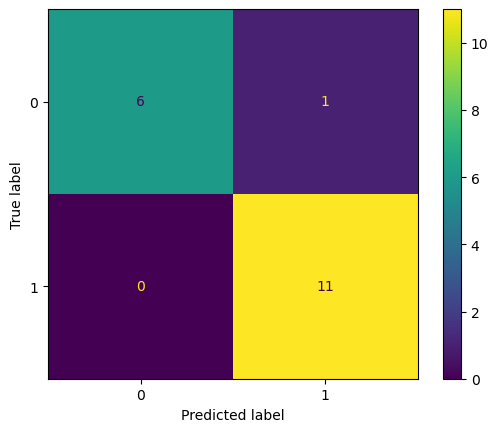

In [164]:
# Create the confusion matrix
cm = confusion_matrix(val_y_ai, y_pred_ai)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is fairly confidence in classifying if a subject is depressed or not.

### Accuracy, Precision, Recall

In [165]:
accuracy = accuracy_score(val_y_ai, y_pred_ai)
precision = precision_score(val_y_ai, y_pred_ai)
recall = recall_score(val_y_ai, y_pred_ai)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9444444444444444
Precision: 0.9166666666666666
Recall: 1.0


Accuracy: In general, when the model makes prediction, it is right 63% of the time.

Precision: This is the accuracy of the Positive Prediction. For 60% precision for "with depression as positive", that means, for a list of patients that our model predicted as depressed, 60% of them IS in fact depressed, while the other 40% is not actually depressed but wrongly predicted as so. The downside is, it does not count missing POSITIVE, that is, our model can pick a few patients where it is confident that they are depressed and achieved High Precision, but left out many patients that are actually depressed but missed out by our model.

Recall: It is the ability of the model to detect the target. If there are 100 depressed patient in a list of X (let say 1000), and our model correctly labelled all 100 depressed patient as depressed, that means the recall is 100%. It does not matter if the model also predicted other non-depressed patient as depressed (False Positive), as it does not count in recall calculation. But too many False Positive can be inconvenient where manual intervention must be made to filter them out and make the labelling correct again.

In this case, with 100% precision, means for all those that this model predict as depressed, it is precisely all of them really are depressed. But with low recall meaning our model is missing (in this case 42%) other patients who are depressed but failed to be detected by our model.

### Classification Report

In [166]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y_ai, y_pred_ai, target_names=target_names))

               precision    recall  f1-score   support

without PPTSD       1.00      0.86      0.92         7
   with PPTSD       0.92      1.00      0.96        11

     accuracy                           0.94        18
    macro avg       0.96      0.93      0.94        18
 weighted avg       0.95      0.94      0.94        18



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

## Saving The Model

## Load The Model

---